In [1]:
%matplotlib inline

# Analyze ISS hippocampal CA1 data
This tutorial shows how to apply Bering to ISS (pciSeq) CA1 data.

in-situ sequencing (ISS) hippocampal CA1 {cite}`qian2020probabilistic` data was derived from: https://doi.org/10.6084/m9.figshare.7150760.v1. 
We took one of the sample (sample 3-1 left CA-1) as an example in this tutorial.

### Import packages & data

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import Bering as br

In [3]:
# load data
df_spots_all = br.datasets.iss_ca1_qian()
df_spots_seg = df_spots_all[df_spots_all['labels'] != 'background'] # foreground nodes
df_spots_unseg = df_spots_all[df_spots_all['labels'] == 'background'] # background nodes
img = None
channels = None

df_spots_seg.head()

,x,y,z,features,segmented,labels
0,209,441,0,Aldoc,67,Basket
2,215,450,0,Gad1,67,Basket
3,220,440,0,Pvalb,67,Basket
4,224,454,0,Slc24a2,67,Basket
5,229,438,0,Gad1,67,Basket


In [4]:
df_spots_unseg.head() # visualize unsegmented data

,x,y,z,features,segmented,labels
1,213,419,0,Pvalb,-1,background
16,270,383,0,3110035E14Rik,-1,background
17,282,436,0,Slc24a2,-1,background
18,287,342,0,3110035E14Rik,-1,background
19,290,436,0,Aldoc,-1,background


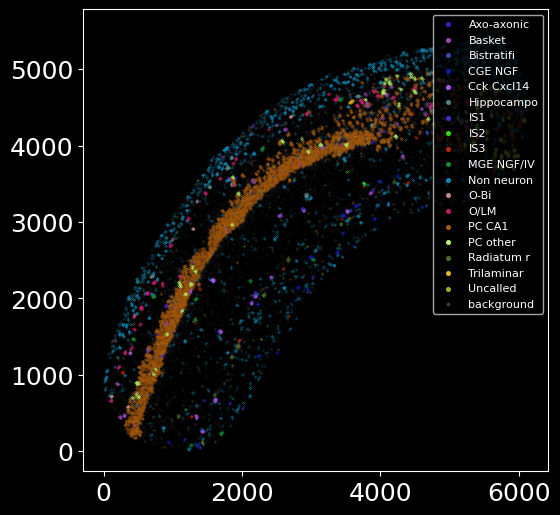

In [5]:
# visualize the spots
x, y = df_spots_seg['x'].values, df_spots_seg['y'].values
cell_types = df_spots_seg['labels'].values

fig, ax = plt.subplots(figsize = (6, 6))
for idx, cell_type in enumerate(np.unique(cell_types)):
    
    xc = x[np.where(cell_types == cell_type)[0]]
    yc = y[np.where(cell_types == cell_type)[0]]

    ax.scatter(xc, yc, s = 0.03, label = cell_type, color = np.random.rand(3,))

xb, yb = df_spots_unseg['x'].values, df_spots_unseg['y'].values
ax.scatter(xb, yb, color = '#DCDCDC', alpha = 0.2, s = 0.015, label = 'background')

h, l = ax.get_legend_handles_labels()
plt.legend(h, l, loc = 'upper right', fontsize = 8, markerscale = 15)

### Create Bering object

In [6]:
# image-dependent segmentation
bg = br.BrGraph(df_spots_seg, df_spots_unseg, img, channels)
bg

In [7]:
bg.segmented.head() # summary of cells

,cx,cy,cz,dx,dy,dz,d,labels
segmented,,,,,,,,
0,236.0,442.0,0.0,41,31,0,41,Basket
1,295.0,467.0,0.0,38,29,0,38,Basket
2,312.5,351.0,0.0,41,28,0,41,PC CA1
3,320.0,394.0,0.0,24,25,0,25,PC CA1
4,330.0,296.0,0.0,32,18,0,32,PC CA1


### Create training data

In [8]:
# Build graphs for GCN training purpose
br.graphs.BuildWindowGraphs(
    bg, 
    n_cells_perClass = 20, 
    window_width = 60.0, 
    window_height = 60.0, 
    n_neighbors = 10, 
)

In [9]:
br.graphs.CreateData(
    bg, 
    batch_size = 16, 
    training_ratio = 0.8, 
)

### Training

Training node classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:26<00:00,  2.54it/s]

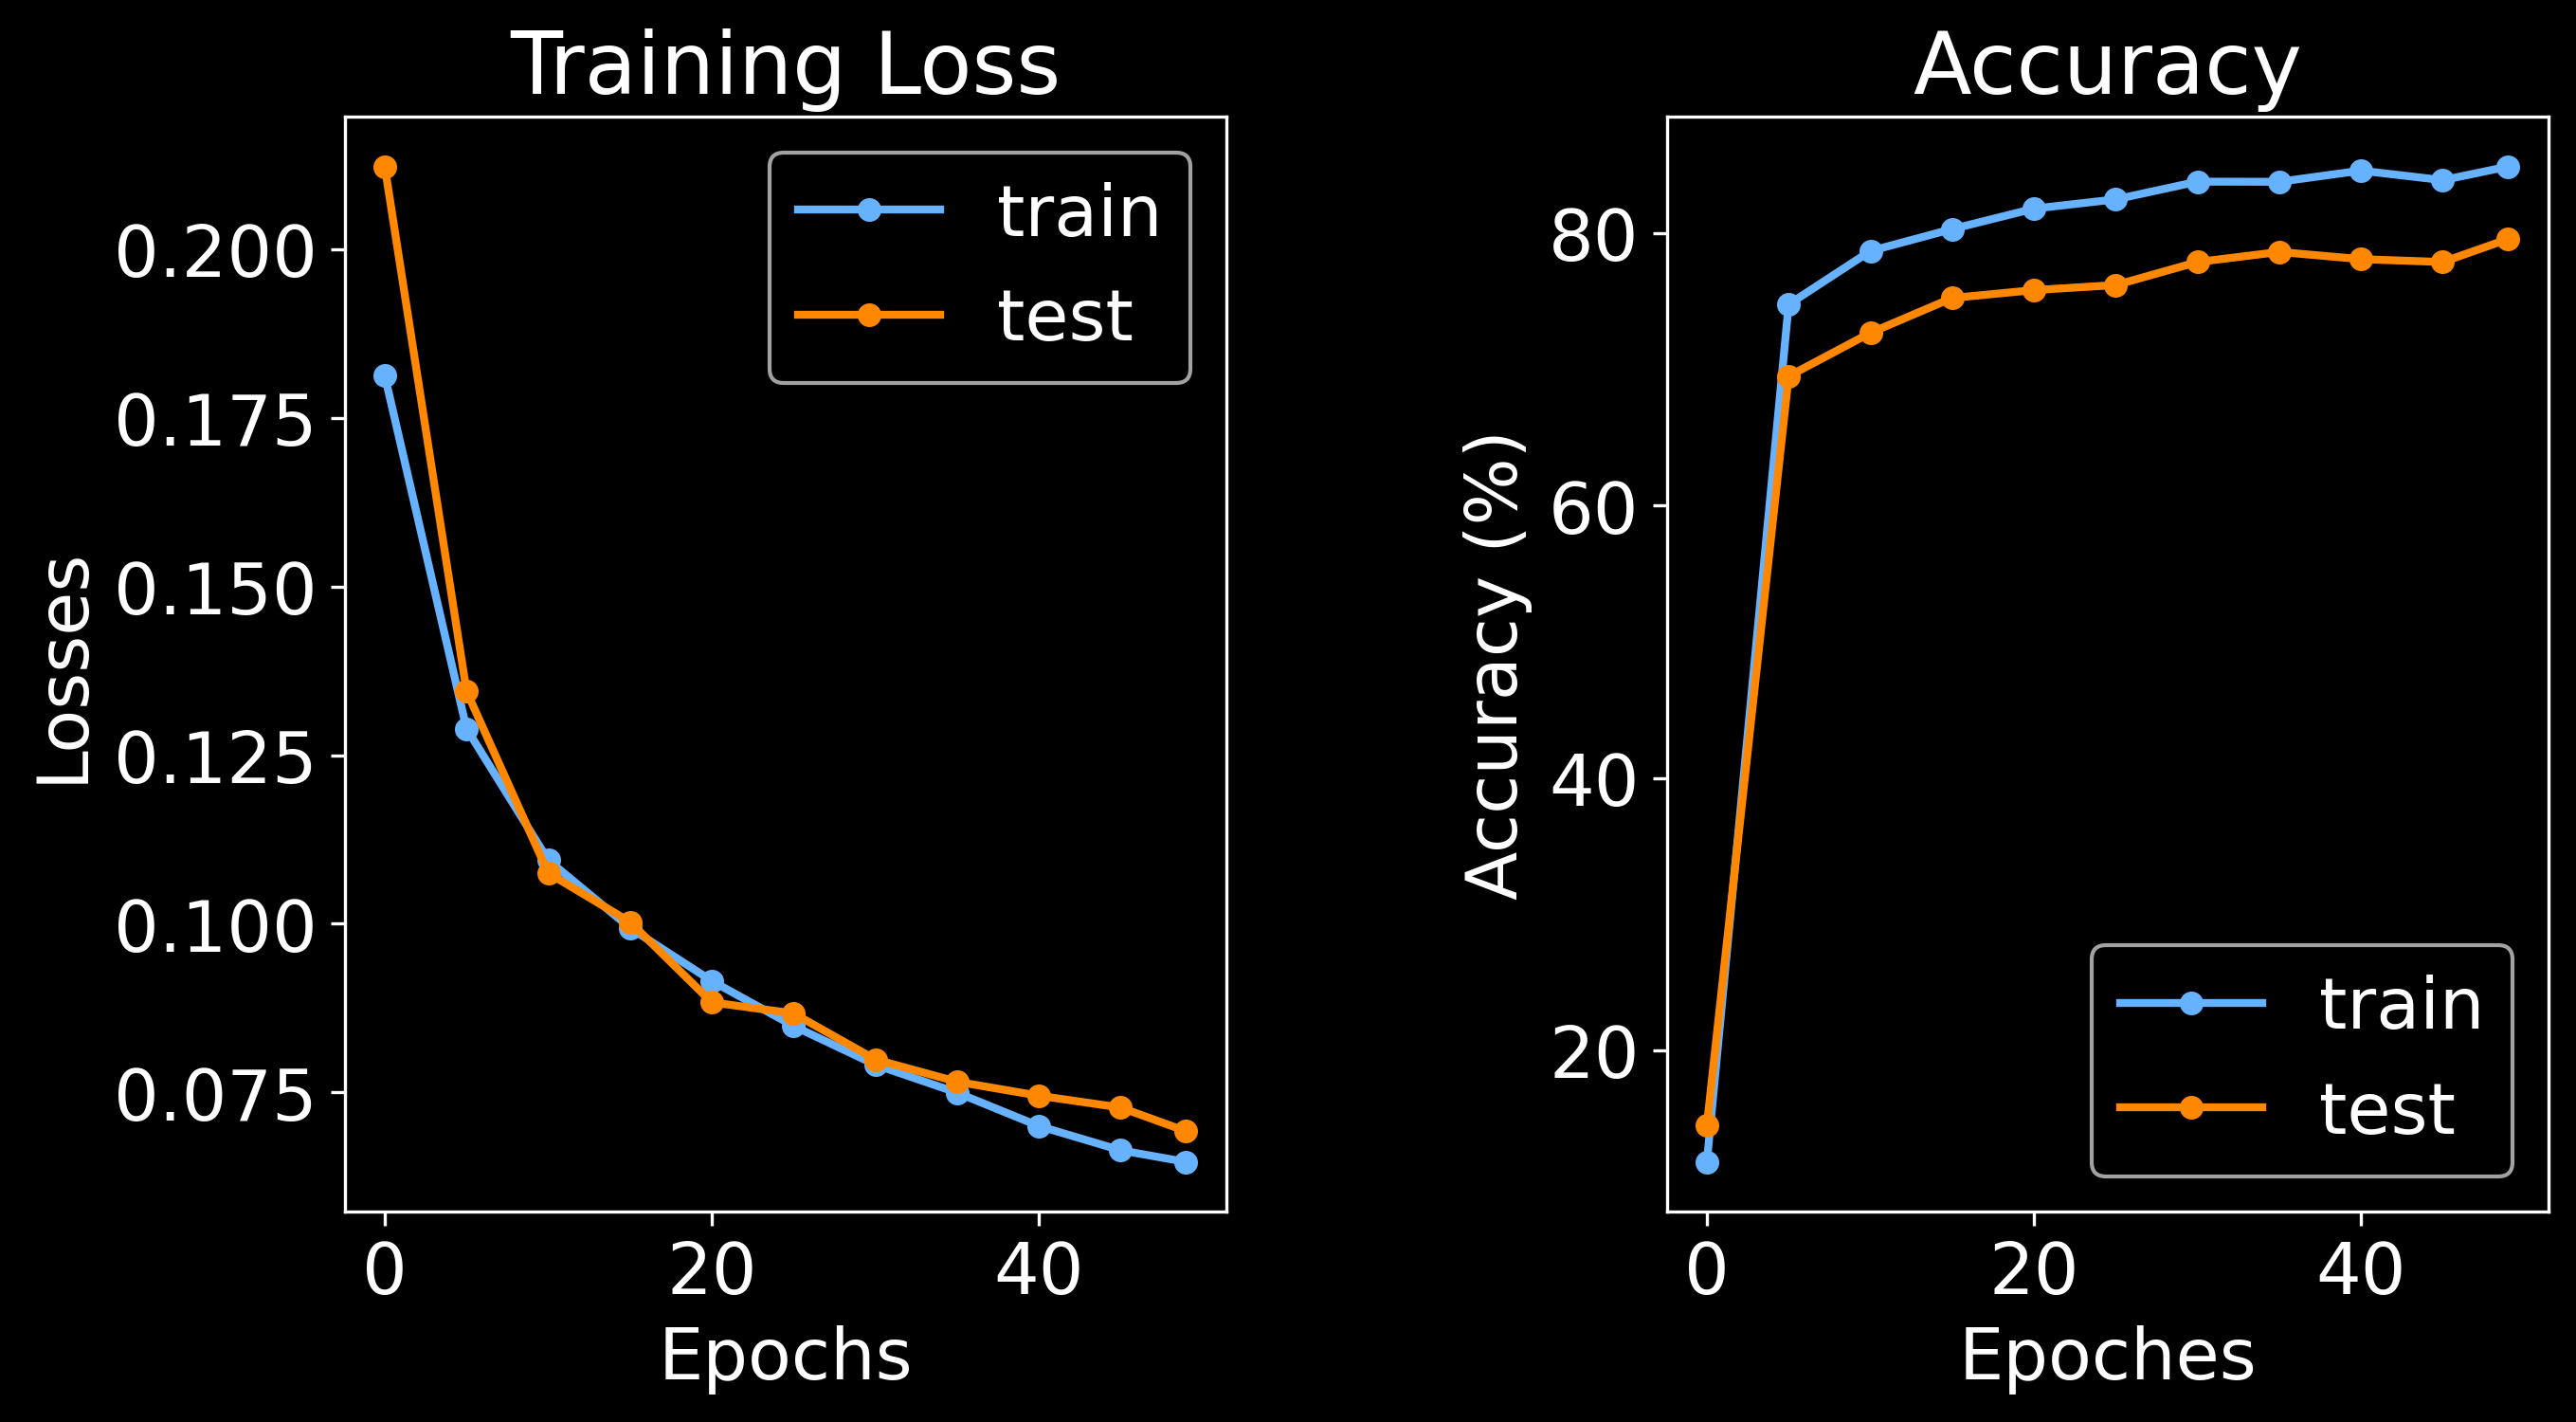

Training edge classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:28<00:00,  1.90it/s]

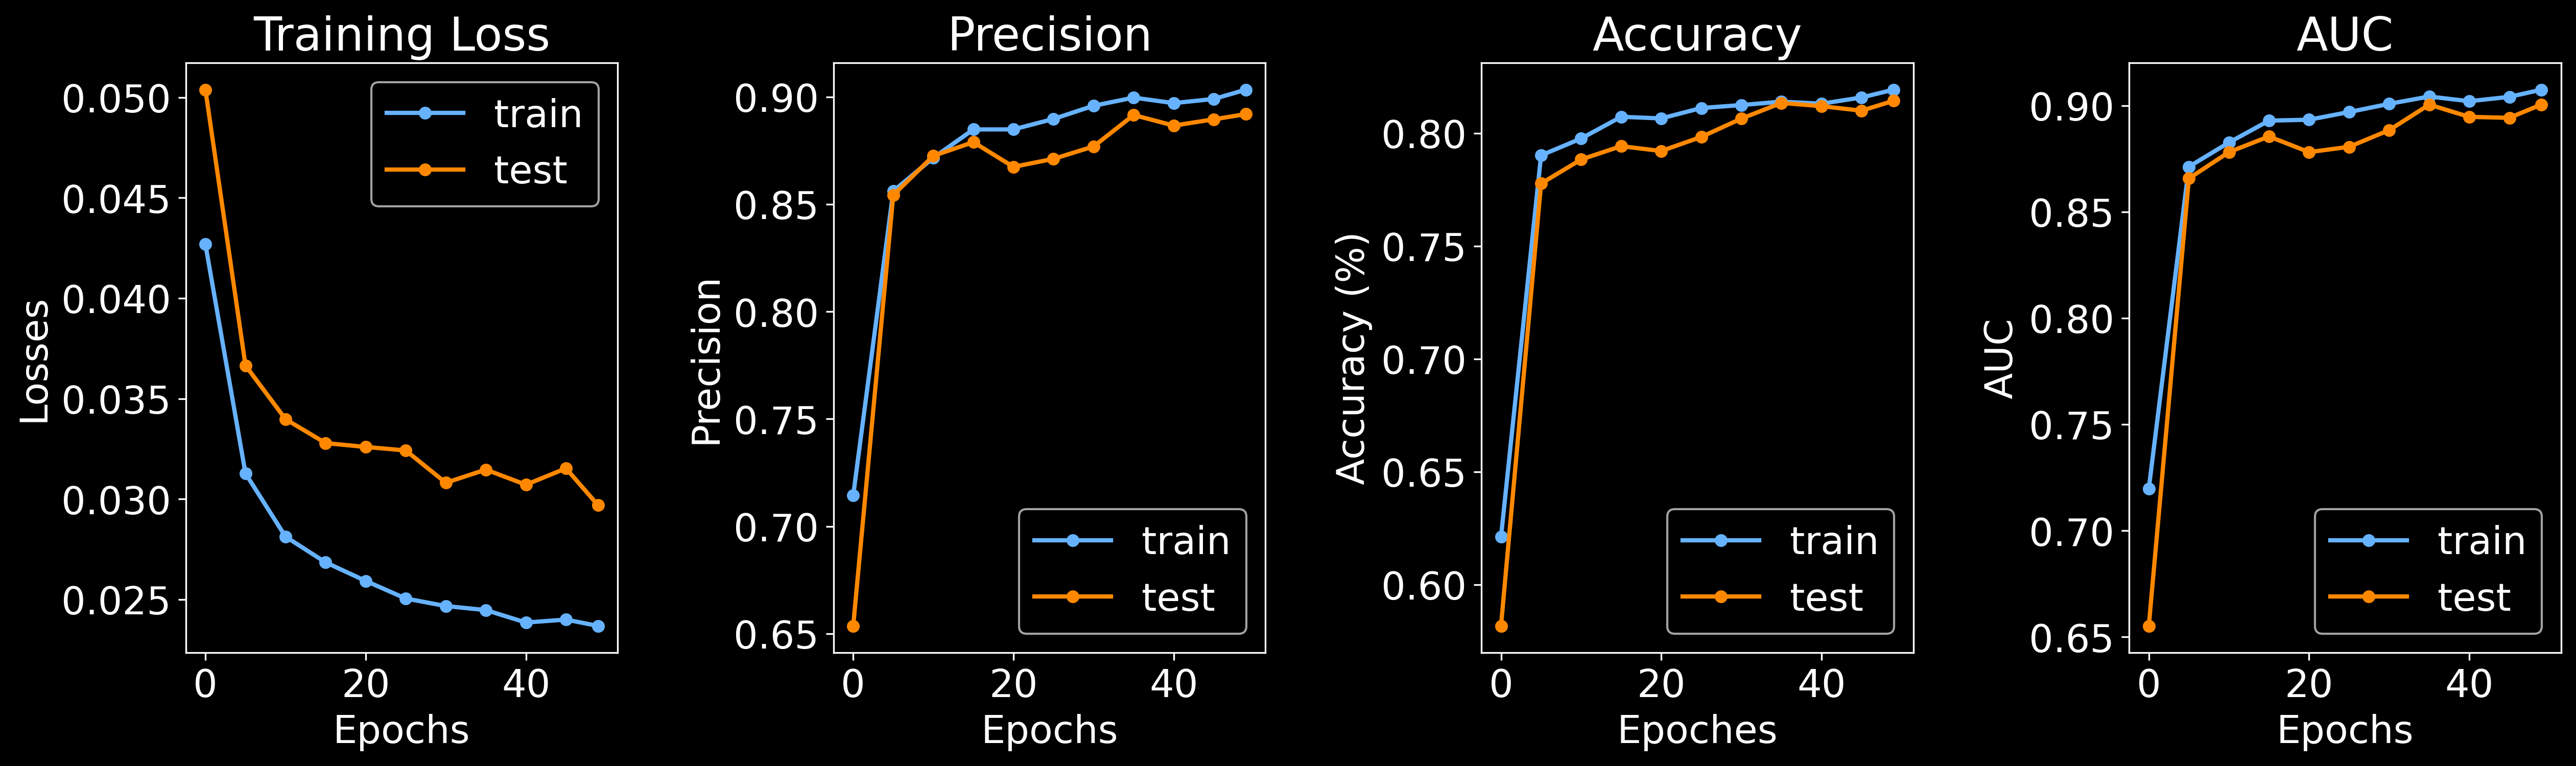

Training edge classifier: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


In [10]:
br.train.Training(
    bg,
    edge_rbf_start = 0,
    edge_rbf_stop = 256,
    edge_rbf_n_kernels = 128,
)

In [11]:
# save the trained model
import pickle
with open('iss_ca1_qian.pkl', 'wb') as f:
    pickle.dump(bg, f)

### Visualizing model

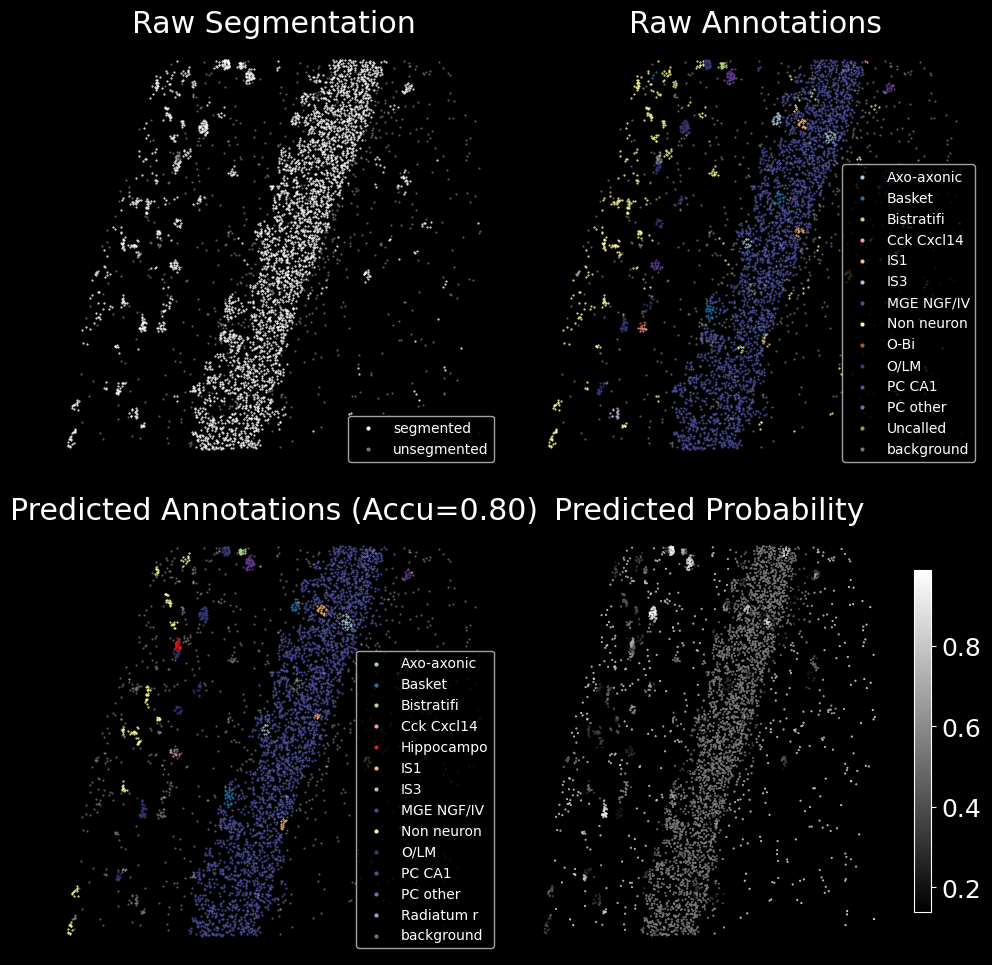

In [12]:
# select middle cell
selected_cell = 362

# plot node classification
df_window_raw, df_window_pred, predictions = br.pl.Plot_Classification(
    bg, 
    cell_name = selected_cell,
    n_neighbors = 10, 
    zoomout_scale = 20,
)

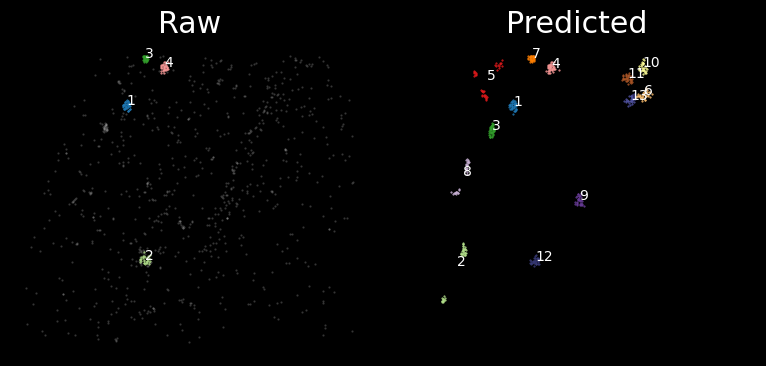

In [13]:
# plot cell segmentation
br.pl.Plot_Segmentation(
    bg, 
    cell_name = selected_cell,
    df_window_raw = df_window_raw, 
    df_window_pred = df_window_pred,
    predictions = predictions,
    n_neighbors = 10, 
    zoomout_scale = 20,
    use_image = True,
    pos_thresh = 0.7,
    resolution = 0.3,
    num_edges_perSpot = 40,
    min_prob_nodeclf = 0.3,
    n_iters = 20,
)

After the model is trained, we can use the trained model to predict the cell types and segment all spots on the whole slice. After node classification and cell segmentation is completed, we generate single cell matrix in the end.

### Node classification
Conduct node classification on the whole slice.

In [14]:
br.tl.node_classification(
    bg, bg.spots_all.copy(), 
    n_neighbors = 10, 
)
bg.spots_all.to_csv('spots_all.txt', sep = '\t')

### Cell segmentation

In [15]:
br.tl.cell_segmentation(
    bg,
    positive_edge_thresh = 0.6,
    leiden_resolution = 0.05,
    num_edges_perSpot = 100,
    graph_n_neighbors = 10,
    num_iters = 20,
)

### Get single cells

In [16]:
df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(
    bg,
    min_dominant_nodes = 5, # set minimum number of nodes per cell as 8, so that we allow cells to be small in pciSeq
    min_dominant_ratio = 0.75,
)
df_results.to_csv('results.txt', sep = '\t')
adata_ensembl.write('results_cells_ensembled.h5ad')
adata_segmented.write('results_cells_segmented.h5ad')

print(f'Ensembled anndata: {adata_ensembl.shape}')
print(f'Segmented anndata: {adata_segmented.shape}')

... storing 'predicted_labels' as categorical


Ensembled anndata: (134, 80)
Segmented anndata: (1022, 84)


### Single cell data analysis

2023-08-22 17:43:26.681080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 17:43:27.644066: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


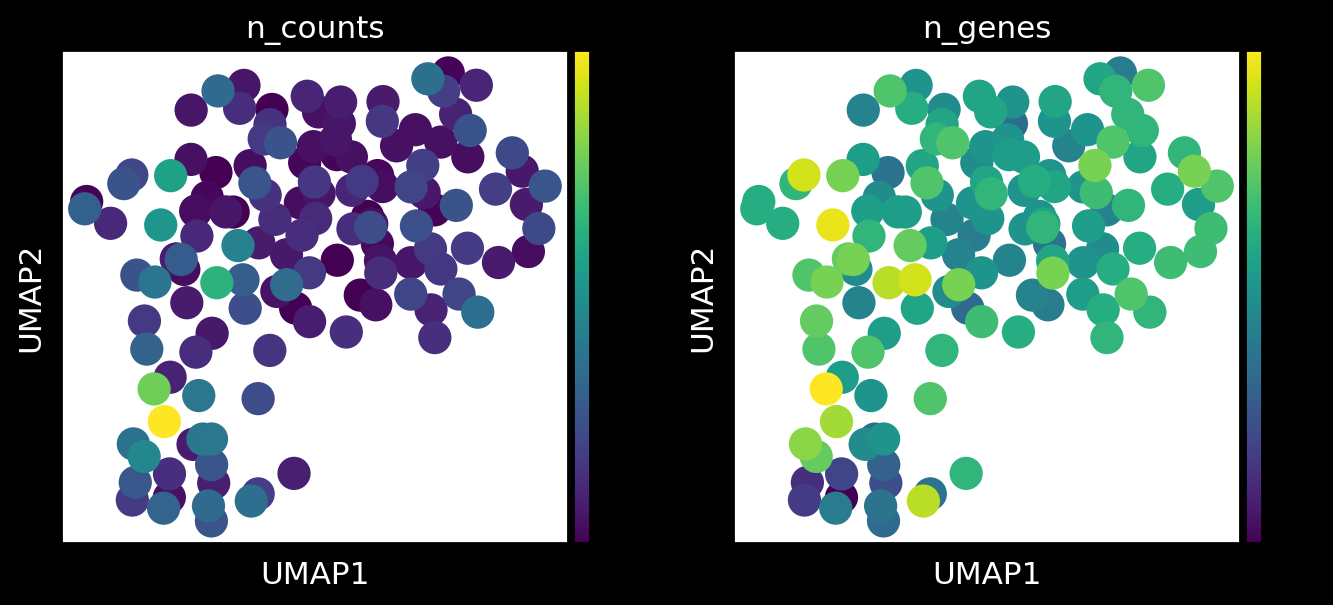

In [17]:
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

# run standard analysis on the ensembled anndata
adata_ensembl = br.tl.cell_analyze(adata_ensembl, min_counts = 5)

# first check the data quality of segmented cells
sc.pl.umap(adata_ensembl, color = ['n_counts','n_genes'])

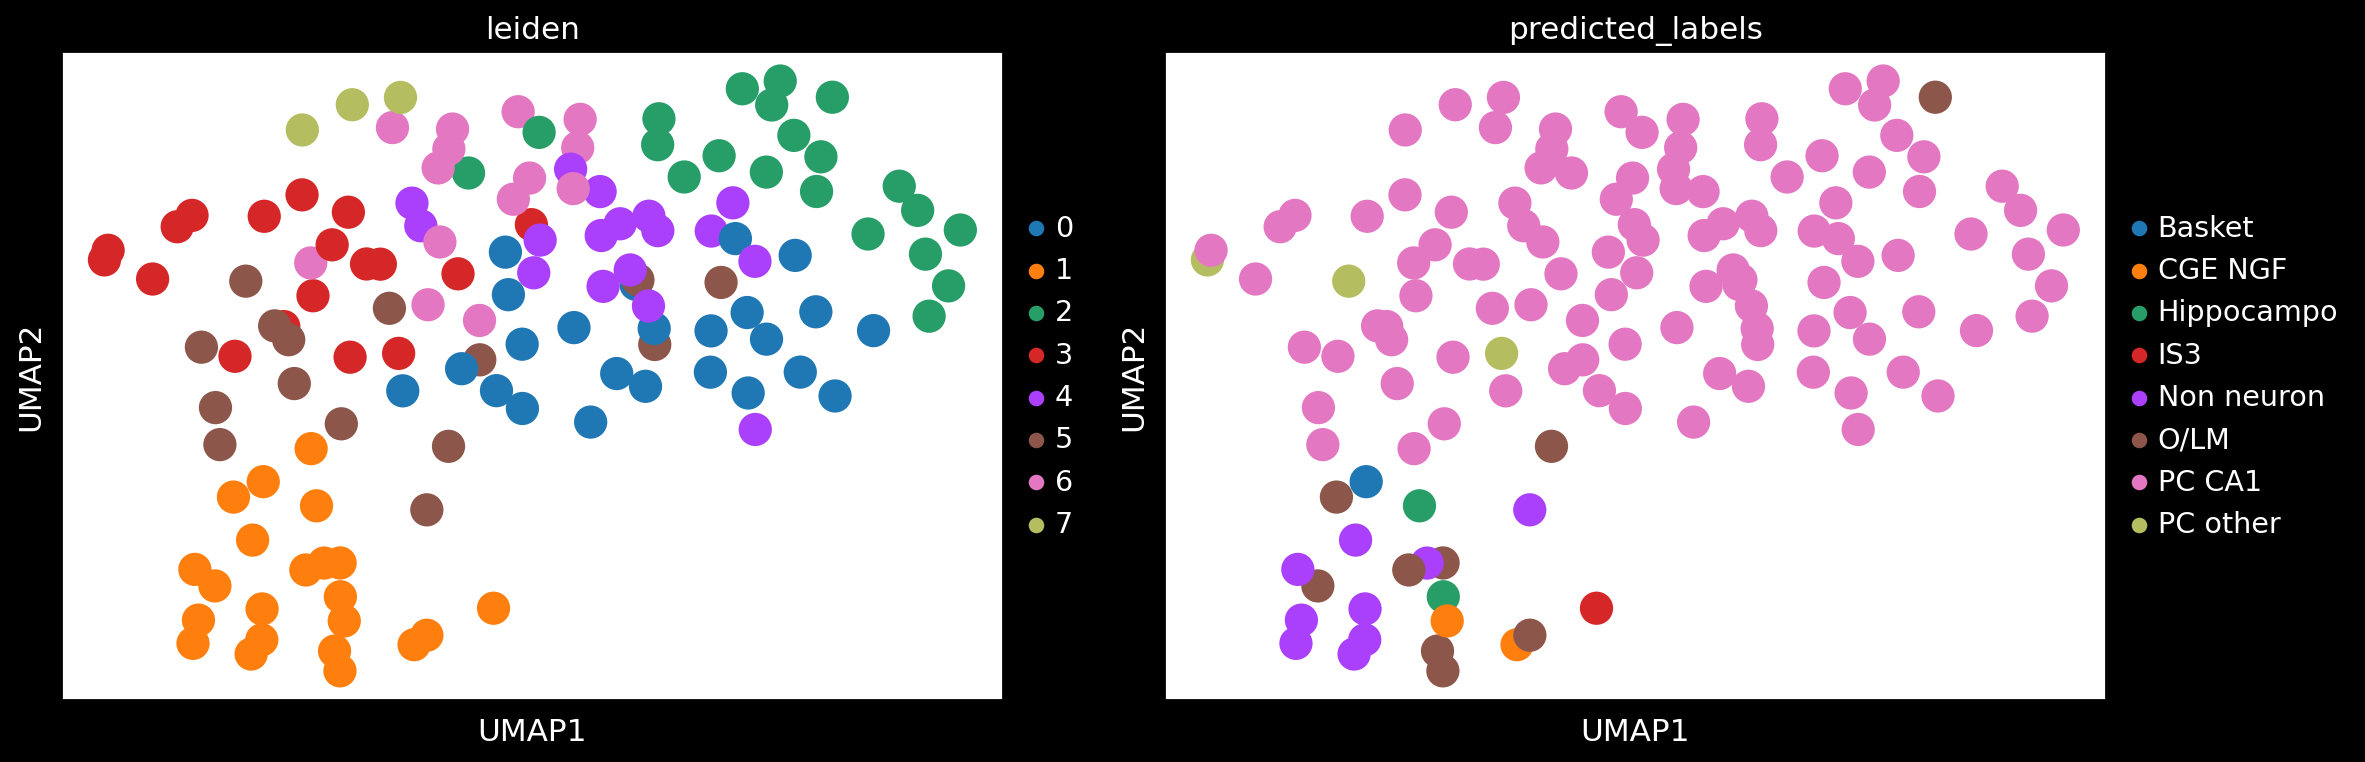

In [18]:
# plot leiden clustering and predicted labels from Bering
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0] = sc.pl.umap(adata_ensembl, color = ['leiden'], ax = axes[0], show = False)
axes[1] = sc.pl.umap(adata_ensembl, color = ['predicted_labels'], ax = axes[1], show = False)

plt.subplots_adjust(wspace = 0.5)
plt.tight_layout()
plt.show()